## Import

In [1]:
import numpy as np
import pandas as pd
import pickle
import logging
from typing import Tuple

import sys
sys.path.append(r'E:\photoelectric_sorting\codes\project_x_ray_images_stack')

from tools.analyzer_two_thresh import BaselineOreGrading
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from src.detection.contour_detecting import contour_detection, get_contour_pixels, get_contour_box_image
from src.detection.image_processing import concat_xray_image, split_dual_xray_image, convert_uint16_to_uint8, \
    crop_image, show_image, draw_contours, compensate_xray_image
import os

In [2]:
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score

In [3]:
from matplotlib import rc

rc('text', usetex=False)
font = {'family': 'serif',
        'serif': 'Times New Roman',
        'weight': 'normal',
        'size': 10}
rc('font', **font)

In [4]:
from pathlib import Path

In [5]:
from importlib import reload
import src.detection.image_processing
reload(src.detection.image_processing)
from src.detection.image_processing import draw_contours

In [6]:
import seaborn as sns

# sns.set_context("notebook")
sns.set_context('talk')
sns.set_style("ticks")
# sns.set_style("whitegrid")

In [7]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
path_excel = "E:/photoelectric_sorting/data/化验结果/20250219化验结果.xlsx"

In [9]:
df = pd.read_excel(path_excel, nrows=110, usecols=range(6))
print(df.head(1))

#把含有空值的某一行，除了第一列都设成0 
df.loc[df.isna().any(axis = 1), df.columns[1:]] = 0
true_0219 = df.iloc[:, 0:6].to_numpy()

   Sample No.      Fe     Zn     Pb      S  Weight(g)
0            1  30.13  0.031  0.063  34.83       39.9


In [10]:
zn_pb_0219 = true_0219[:, 2] + true_0219[:, 3]
zn_pb_fe_0219 = true_0219[:, 2] + true_0219[:, 3] + true_0219[:, 1]
weight = true_0219[:, 5]

In [11]:
zn_pb_0219[63].dtype

dtype('float64')

## definitions

In [121]:
def R_from_path(path, roi, I0_low, I0_high, input = 'images', method = 'a', const = [5, 20],
                max_len = 6, length = 100, s_i = 0, direction = 'ublr', save_rock_image = False):
    
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
    # cv2.IMREAD_GRAYSCALE 或 0， 转换为0-255的灰度图
    # cv2.IMREAD_COLOR 或 1，转换为3通道的彩色图
    # cv2.IMREAD_UNCHANGED 或 -1， 保持原来的不变

    low, high = split_dual_xray_image(image.T) #为了与函数输入一致，先将图像transpose

    low, high = low.T, high.T # 先转置回来

    y1, y2, x1, x2 = roi

    low, high = cv2.flip(low[y1:y2, x1:x2], 0), cv2.flip(high[y1:y2, x1:x2], 0) 
    # 先选择感兴趣区域
    # X射线探测器成像与实际矿石摆放位置（俯视）差180°且左右相反
    # 等效为沿着垂直方向翻转

    low_contoured, rock_pixels, contours = get_contours(low, high, th_val = 105, max_len = max_len, length=length, 
                                              direction = direction, path = path, s_i = s_i, save_rock_image=save_rock_image)
         
    R_images = compute_R(low, high, I0_low, I0_high, input = 'images', method= method, const=const)
    
    if input == 'pixels':
        R_pixels = compute_R(rock_pixels[0], rock_pixels[1], I0_low, I0_high, input = input, method= method, const=const)
        return R_pixels, R_images, low, high, low_contoured, rock_pixels, contours    
    else:
        return R_images, low, high, low_contoured, rock_pixels, contours

def compute_R(low, high, I0_low, I0_high, input = 'images', method = 'a', const = [5, 20]):

    '''
    input: 'images' or 'pixels', whole images of low and high energy or pixels of rocks
    
    '''

    if input == 'images':
        if method == 'a':
            return np.log(I0_low/(low+1e-6) + const[0] )/np.log(I0_high/(high+1e-6) + const[1])

        elif method == 'b':
            return np.log((low + 1e-6))/(np.log(high+1e-6 + 200.0))
         
    elif input == 'pixels':
        R_values = []
        for i in range(len(low)):

            if method == 'a':
                R_i =np.log(I0_low/(low[i]+1e-6) + const[0] )/np.log(I0_high/(high[i]+1e-6) + const[1])

            elif method == 'b':
                R_i = np.log((low[i] + 1e-6))/(np.log(high[i]+1e-6 + 200.0))   
            R_values.append(R_i)

        return R_values     

    
def get_contours(low, high, th_val = 100, max_len = 6, length = 100, direction = 'ublr', path = '', s_i = 0, save_rock_image = False):
        
        path = Path(path)

        _contours = contour_detection(low, roi=(None, None, None, None), th_val=th_val)
        
        low_contoured, contours = draw_contours_yao(low, _contours, thickness=2, show = 'index', max_len=max_len, length=length,
                                          indexes=s_i + np.arange(len(_contours)), direction=direction)
        # low_rock_images = []
        # high_rock_images = []
        rock_pixels = [[], []]
        for i in range(len(contours)):
                contour = contours[i]
                # low_rock_images.append(get_contour_box_image(low, contour, margin=10))
                # high_rock_images.append(get_contour_box_image(high, contour, margin=10))
                rock_pixels[0].append(get_contour_pixels(low, contour))
                rock_pixels[1].append(get_contour_pixels(high, contour))
                if save_rock_image:
                    cv2.imwrite(path.parent/('rocks/%s_%s_low.png'%(path.name, s_i + i)), get_contour_box_image(low, contour, margin=10))
                    cv2.imwrite(path.parent/('rocks/%s_%s_high.png'%(path.name, s_i + i)), get_contour_box_image(high, contour, margin=10))
        return low_contoured, rock_pixels, contours

def draw_contours_yao(image, contours, color=(0, 0, 255), thickness=2, max_len = 6, 
                      length = 100, show= 'index', indexes=None, direction = 'ublr', grade = None):
    '''

    width: the width of each row. 当图像转置之后，将会行变列，所以width 应该是列宽 0304
    length: the width of each column
    direction: ublr or lrub， 从上到下再从左到右， 或先从左到右再从上到下
    '''
    # Create a copy of low_img for visualization
    contour_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR).copy()
    cv2.drawContours(contour_image, contours, -1, color, thickness)

    if show == 'index':

        if direction == 'ublr':
            # 从上到下再从左到右
            # contours = sorted(contours, key=lambda c: ((cv2.boundingRect(c)[0] + cv2.boundingRect(c)[2]/2.0)//length, (cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3]) //width))
            contours = sort_contours(contours, tolerance=length, max_len=max_len, direaction='y')
        elif direction == 'lrub':
            # 先从左到右再从上到下
            # contours = sorted(contours, key=lambda c: ((cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3]/2.0) //width, cv2.boundingRect(c)[0] // length)) 
            contours = sort_contours(contours, tolerance=length, max_len=max_len, direaction='x')
        if indexes is None:
            indexes = range(len(contours))
            text = indexes
        else:
            text = [str(i) for i in indexes]
        
    elif show == 'grade':
        # in this case contours should already be sorted
        assert grade is not None, 'grade must be provided'
        text = np.around(grade, decimals=2)

    for contour, text_i in zip(contours, text):
        # Calculate the centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        # Put the index number near the contour
        cv2.putText(contour_image, str(text_i), (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 0), 2)
    # print(cv2.boundingRect(contours[7]), cv2.boundingRect(contours[8]))
    return contour_image, contours

# 根据轮廓质心位置对阈值分割的轮廓进行排序
def sort_contours(contours, tolerance=35, max_len=9, direaction='y', reverse=False):
    """
    根据阈值分割的轮廓进行排序,实现的排序方式有两种,分别是沿x方向和y方向,以下注释以y方向为例
    参数说明：
    contours: 根据cv2阈值分割得到的轮廓;
    tolerance: 表示在x或y方向上的容忍值,在范围内表示同一行或同一列;
    输出结果：
    根据需求排序后的轮廓
    x方向: 从左上角开始,从左到右,从上到下排列轮廓序号结果；
    y方向: 从左上角开始,从上到下,从左到右排列轮廓序号结果;
    reverse: 根据图像采集成像左右翻转设置的参数
    """
    if direaction == 'x':
        sort_index = 1
        group_index = 0
    elif direaction == 'y':
        sort_index = 0
        group_index = 1
    else:
        raise TypeError("Must be sorted along the x or y direction.")
    # 根据轮廓计算质心位置
    centers = [get_contour_centroid(cnt) for cnt in contours]
    
    # 初步排序：根据x值或y值从小到大排列
    sorted_indices = sorted(range(len(centers)), key=lambda i: centers[i][sort_index])
    sorted_contours = [contours[i] for i in sorted_indices]
    sorted_centers = [centers[i] for i in sorted_indices]
    # print(sorted_contours)
    
    # 分组处理：首先按纵列分组，再在每个纵列内按横坐标分组和排序
    groups = []
    current_group = []
    previous = None
    for cnt, center in zip(sorted_contours, sorted_centers):
        # print(x,y)
        if previous is None:
            current_group.append((cnt, center[group_index]))
            previous = center[sort_index]
        else:
            # 检查是否在同一纵列
            if abs(center[sort_index] - previous) <= tolerance and len(current_group) < max_len:
                current_group.append((cnt, center[group_index]))
                previous = center[sort_index]
            else:
                # 对当前纵列内的轮廓按x排序，并添加到组列表中
                current_group_sorted = sorted(current_group, key=lambda item: item[1], reverse=reverse)
                groups.extend([item[0] for item in current_group_sorted])
                current_group = [(cnt, center[group_index])]
                previous = center[sort_index]
    
    # 处理最后一个纵列
    if current_group:
        current_group_sorted = sorted(current_group, key=lambda item: item[1], reverse=reverse)
        groups.extend([item[0] for item in current_group_sorted])
    
    return groups

def get_contour_centroid(contour):
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        # warnings.warn("Contour area is zero. Returning (0, 0) as centroid.")
        cX, cY = 0, 0

    return cX, cY


In [13]:
def append_generic(arr1, arr2):
    if isinstance(arr1, np.ndarray):
        return np.concatenate((arr1, arr2))
    elif isinstance(arr1, list):
        # 检查列表元素是否还是列表
        if all(isinstance(i, list) for i in arr1) and all(isinstance(i, list) for i in arr2):
            result = [sub_arr1 + sub_arr2 for sub_arr1, sub_arr2 in zip(arr1, arr2)]
            return result
        else:
            return arr1 + arr2
    else:
        raise TypeError("Unsupported type")
    
list1 = [1, 2] 
list2 = [3, 4]
print(append_generic(list1, list2))


list1 = [[1, 2], [3,4]]
list2 = [[5,6], [7,8]]
print(append_generic(list1, list2))

[1, 2, 3, 4]
[[1, 2, 5, 6], [3, 4, 7, 8]]


In [139]:
def calculate_rates(predictions, true_results, count_Fe = False):
    '''
    计算抛废率、回收率、铅锌富集比、铅锌平均品位
    :param predictions: 预测结果，一维数组
    :param true_results: 真实结果，excel表格
    
    :return: 抛废率、回收率、铅锌富集比、铅锌平均品位
    '''
    high_grade_mask = predictions == 1
    low_grade_mask = predictions == 0

    Fe_grade = true_results[:, 1]
    zn_grade = true_results[:, 2]
    pb_grade = true_results[:, 3]
    zn_pb_grade = zn_grade + pb_grade

    if count_Fe:
        zn_pb_grade = zn_grade + pb_grade + Fe_grade

    weight = true_results[:, 5]

    miss = (zn_grade == 0).sum()
    correction = len(predictions)/(len(predictions) - miss)

    # 计算抛废率和回收率
    scrap_rate = weight[low_grade_mask].sum() / weight.sum()
    recovery_rate = (weight[high_grade_mask] * zn_pb_grade[high_grade_mask]).sum() / (weight * zn_pb_grade).sum()

    # 计算富集率
    avg_pb_grade_all = pb_grade.mean()*correction
    avg_zn_grade_all = zn_grade.mean()*correction

    avg_pb_grade_high = (pb_grade[high_grade_mask] * weight[high_grade_mask]).sum()/weight[high_grade_mask].sum()
    avg_zn_grade_high = (zn_grade[high_grade_mask] * weight[high_grade_mask]).sum()/weight[high_grade_mask].sum()
    avg_pb_grade_low = (pb_grade[low_grade_mask] * weight[low_grade_mask]).sum()/weight[low_grade_mask].sum()
    avg_zn_grade_low = (zn_grade[low_grade_mask] * weight[low_grade_mask]).sum()/weight[low_grade_mask].sum()

    # avg_pb_grade_high = pb_grade[high_grade_mask].mean()*correction
    # avg_zn_grade_high = zn_grade[high_grade_mask].mean()*correction
    # avg_pb_grade_low =  pb_grade[low_grade_mask].mean()*correction
    # avg_zn_grade_low = zn_grade[low_grade_mask].mean()*correction

    enrichment_Pb = avg_pb_grade_high / avg_pb_grade_all if avg_pb_grade_all != 0 else 0
    enrichment_Zn = avg_zn_grade_high / avg_zn_grade_all if avg_zn_grade_all != 0 else 0

    return {
        '抛废率': '%.3f'%scrap_rate,
        '回收率': '%.3f'%recovery_rate,
        # '铅富集比': enrichment_Pb,
        # '锌富集比': enrichment_Zn,
        # '铅平均品位（保留）': avg_pb_grade_high,
        # '锌平均品位（保留）': avg_zn_grade_high,
        # '铅平均品位（抛废）': avg_pb_grade_low,
        # '锌平均品位（抛废）': avg_zn_grade_low,
        # '铅平均品位': avg_pb_grade_all,
        # '锌平均品位': avg_zn_grade_all,
    }


def find_closest_point(scrap_rates, recovery_rates, target= [20, 95]):
    '''
    找到回收率最接近目标回收率的抛废率， 或者最接近目标抛废率的回收率。

    :param scrap_rates: 抛废率列表
    :param recovery_rates: 回收率列表
    :param target: 目标回收率

    :return: 最接近目标回收率的抛废率

    '''
    scrap_rates = np.array(scrap_rates)
    recovery_rates = np.array(recovery_rates)
    
    min_index_scrap = np.argmin(np.abs(scrap_rates - target[0]))
    min_index_recovery = np.argmin(np.abs(recovery_rates - target[1]))

    closest_scrap = [scrap_rates[min_index_scrap], recovery_rates[min_index_scrap]]
    closest_recovery = [scrap_rates[min_index_recovery], recovery_rates[min_index_recovery]]
    return [closest_scrap, closest_recovery]

def get_and_plot_rates(R_mean, range, true, condition, count_Fe = False, accurace_weight = None, title = '', plot = False):
    '''
    计算并画出抛废率和回收率随R阈值变化的曲线
    :param R_mean: R值的均值
    :param range: R阈值的范围
    :param true: 真实的化验数据
    :param condition: 认为是精矿的条件
    '''

    final = [[], [], [], []]

    for r in np.arange(*range):
        pre = R_mean >  r
        res = calculate_rates(pre, true, count_Fe=count_Fe)
        score = accuracy_score(condition, pre, sample_weight=accurace_weight)
        # print('%.3f'%r, '%.3f'%score, res)

        final[0].append(r)
        final[1].append(score*100)
        final[2].append(float(res['抛废率'])*100)
        final[3].append(float(res['回收率'])*100)

    if plot:

        # plt.axhline(y=95, color='k', linestyle='--', alpha = 0.5, label = '95%')

        # plt.axvline(x=0.72, color='k', linestyle='--', alpha = 0.5, label = '$R_{thresh} = 0.72$')
        # plt.axvline(x=0.70, color='k', linestyle='--', alpha = 0.5, label = '$R_{thresh} = 0.70$')

        # plt.text(x = 0.73, y = 92, s = 'R = 0.72, scrap%=35%, \n recovery%=94%', fontsize = 15)
        plt.plot(final[0], final[1], label = 'classification score')
        plt.plot(final[0], final[2], label = 'scrap rate')
        plt.plot(final[0], final[3], label = 'recovery rate')
        
        plt.legend(fontsize = 15, frameon = False)
        plt.xlabel('R threshold')
        plt.ylabel('Rates (%)')
        plt.title(title)
        plt.show()

    return final

## analysis

In [140]:
I0_low, I0_high = 195, 196
path_0219 = "E:/photoelectric_sorting/data/20250219/160kV_4mA_forward.png"
path_0217 = "E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/160kV_4mA.png" #[110, 1000, 400, 1200]

#R_0219_pixels, R_0219_image, low_0219, high_0219, low_contoured_19, rock_pixels_19, contours

consts = [5, 20]
results_0219_second = R_from_path(path_0219, [105, 1000, 400, 1200], I0_low, I0_high, 
                                  input = 'pixels', method = 'a', max_len = 6, length=102, 
                                  direction = 'ublr', s_i = 64, save_rock_image=False, const=consts)

results_0219_first = R_from_path(path_0219, [1950,-100, 350,1150], I0_low, I0_high, 
                                 input = 'pixels', method = 'a', max_len = 9, length=35, 
                                 direction = 'ublr', s_i = 1, save_rock_image=False, const = consts)

results_0219 =[append_generic(results_0219_first[i], results_0219_second[i]) for i in range(6)]

R_0219_mean = np.array([results_0219[0][i].mean() for i in range(105)])

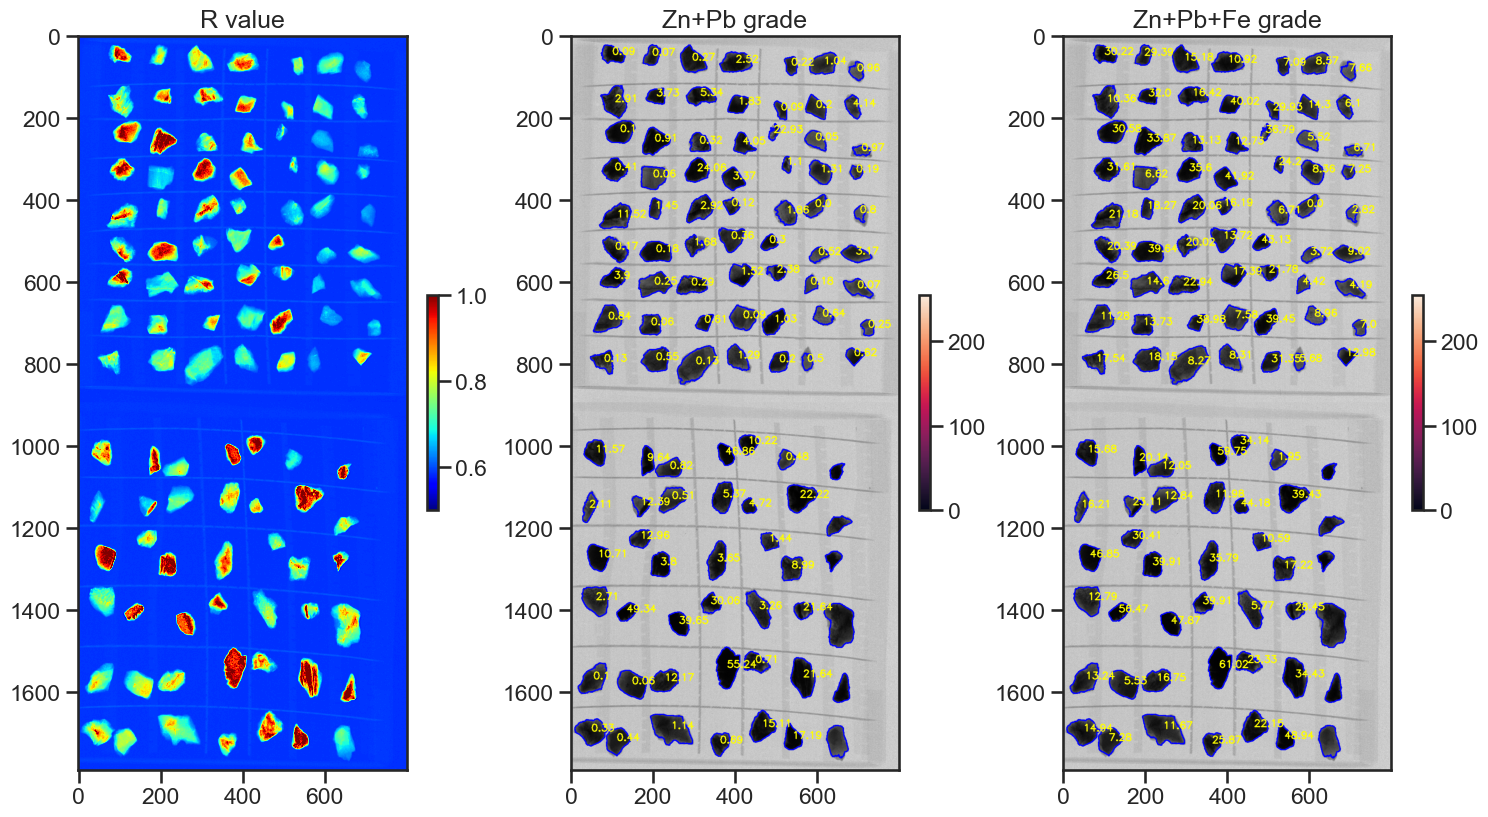

In [143]:
grade_image1, _ = draw_contours_yao(results_0219_first[2], results_0219_first[-1], color=(0, 0, 255), thickness=2, max_len = 6, 
                      length = 100, show= 'grade', indexes=None, direction = 'ublr', grade = zn_pb_0219[0:63])
grade_image2, _ = draw_contours_yao(results_0219_second[2], results_0219_second[-1], color=(0, 0, 255), thickness=2, max_len = 6, 
                      length = 100, show= 'grade', indexes=None, direction = 'ublr', grade = zn_pb_0219[63:99])

grade_image = np.concatenate((grade_image1, grade_image2))

grade_image1_fe, _ = draw_contours_yao(results_0219_first[2], results_0219_first[-1], color=(0, 0, 255), thickness=2, max_len = 6, 
                      length = 100, show= 'grade', indexes=None, direction = 'ublr', grade = zn_pb_fe_0219[0:63])
grade_image2_fe, _ = draw_contours_yao(results_0219_second[2], results_0219_second[-1], color=(0, 0, 255), thickness=2, max_len = 6, 
                      length = 100, show= 'grade', indexes=None, direction = 'ublr', grade = zn_pb_fe_0219[63:99])

grade_image_fe = np.concatenate((grade_image1_fe, grade_image2_fe))

fig, axes = plt.subplots(1,3, figsize=(18,14))
im = axes[0].imshow(results_0219[1][:, :], vmin = 0.5, vmax = 1, cmap = 'jet')
axes[0].set_title('R value')
fig.colorbar(im, ax=axes[0], shrink=0.2)
# im6 = axes[1].imshow(results_0219[4][:, :])
im6 = axes[1].imshow(grade_image)
fig.colorbar(im6, ax = axes[1], shrink=0.2)
axes[1].set_title('Zn+Pb grade')
im7 = axes[2].imshow(grade_image_fe)
fig.colorbar(im7, ax = axes[2], shrink=0.2)
axes[2].set_title('Zn+Pb+Fe grade')
plt.show()

In [103]:
calculate_rates(zn_pb_fe_0219[0:99] > 10.0, true_0219[0:99, :])

{'抛废率': '0.212', '回收率': '0.969'}

### 普通R值+阈值法

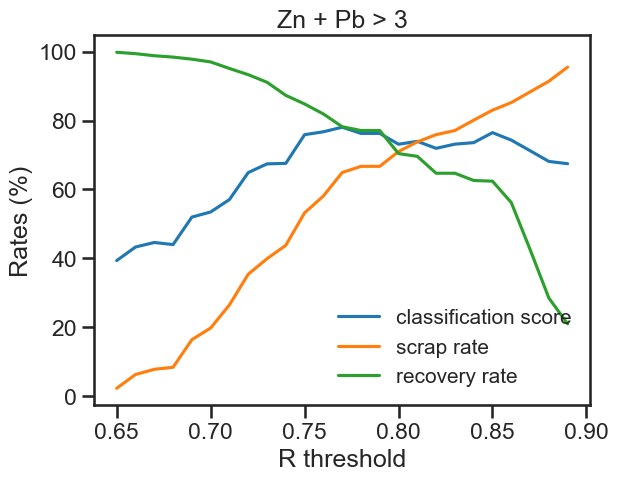

[[19.8, 97.0], [26.5, 95.1]]


In [147]:
test_r = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9, 0.01], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=weight[0:99], plot=True)
print(find_closest_point(test_r[2], test_r[3]))

In [148]:
final_0219_by_weight = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=weight[0:99])

final_0219_no_weight = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=None)

final_0219_by_zn_pb_grade = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_0219[0:99] > 3, title = 'Zn + Pb > 3', accurace_weight=zn_pb_0219[0:99])

final_0219_by_zn_pb_fe_grade = get_and_plot_rates(R_0219_mean[:99], [0.65, 0.9], true_0219[0:99, :], 
                   zn_pb_fe_0219[0:99]> 10, title = 'Zn + Pb + Fe> 10', accurace_weight=zn_pb_fe_0219[0:99], plot=False)

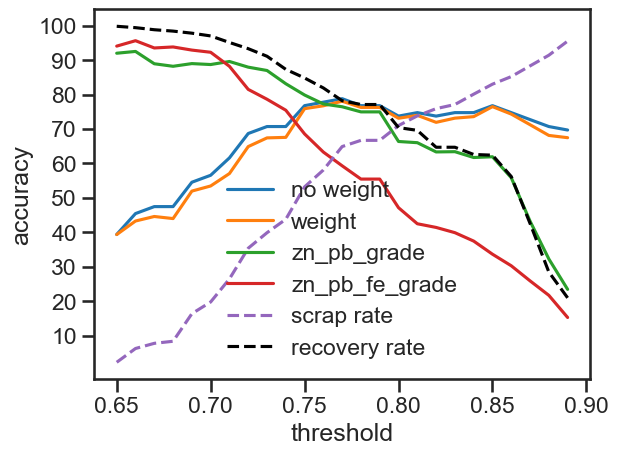

In [87]:
plt.plot(final_0219_no_weight[0], final_0219_no_weight[1], label = 'no weight')
plt.plot(final_0219_by_weight[0], final_0219_by_weight[1], label = 'weight')
plt.plot(final_0219_by_zn_pb_grade[0], final_0219_by_zn_pb_grade[1], label = 'zn_pb_grade')
plt.plot(final_0219_by_zn_pb_fe_grade[0], final_0219_by_zn_pb_fe_grade[1], label = 'zn_pb_fe_grade')

plt.plot(final_0219_no_weight[0],final_0219_no_weight[2], '--', label = 'scrap rate')
plt.plot(final_0219_no_weight[0],final_0219_no_weight[3], 'k--', label = 'recovery rate')

plt.yticks(np.arange(10, 101, 10))
plt.ylabel('accuracy')
plt.xlabel('threshold')
plt.legend(frameon = False)
plt.show()

In [24]:
results_dual_thresh = np.load('results_dual_thresh.npy')

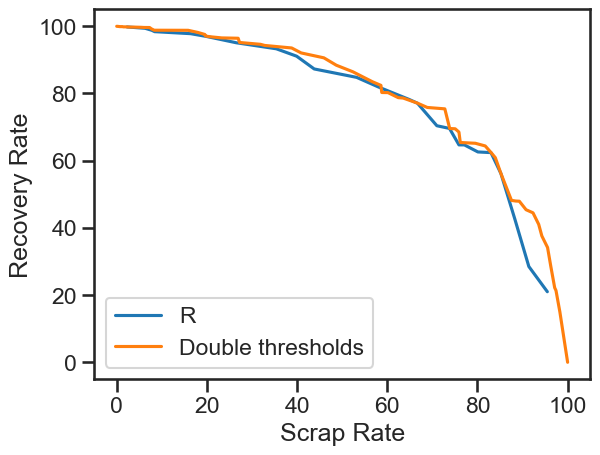

In [32]:

plt.plot(final_0219[2], final_0219[3], label = 'R')
plt.plot(results_dual_thresh[0]*100, results_dual_thresh[1]*100, label = 'Double thresholds')
plt.xlabel('Scrap Rate')
plt.ylabel('Recovery Rate')
plt.legend()
plt.show()

#### test on 0217 data

In [869]:
#R_0219_pixels, R_0219_image, low_0219, high_0219, low_contoured_19, rock_pixels_19, contour
results_0217 = R_from_path(path_0217, [None, None, None, None], I0_low, I0_high, 
                            input = 'pixels', method = 'a', max_len = 7, length=35,
                            direction = 'lrub', s_i = 0, save_rock_image=False)

In [874]:
R_0217_mean = np.array([results_0217[0][i].mean() for i in range(42)])
true_0217 = [1]*21 + [0]*21

In [929]:
for r in np.arange(0.7, 0.85, 0.01):
    print('%.2f'%r, '%.2f'%accuracy_score(true_0217, R_0217_mean > r, normalize=True))

0.70 0.86
0.71 0.88
0.72 0.93
0.73 0.95
0.74 0.95
0.75 1.00
0.76 1.00
0.77 0.95
0.78 0.90
0.79 0.90
0.80 0.88
0.81 0.88
0.82 0.88
0.83 0.83
0.84 0.81
0.85 0.79


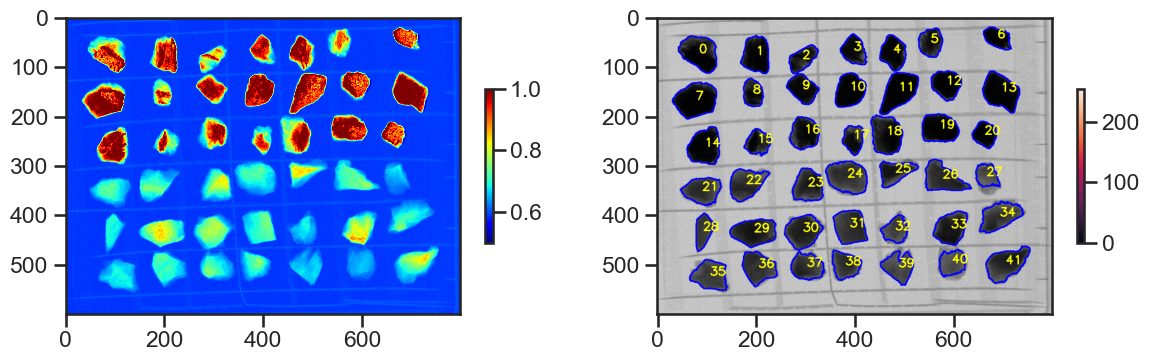

In [927]:
fig, axes = plt.subplots(1,2, figsize=(14,4))
im = axes[0].imshow(results_0217[1][50:650, 400:1200], vmin = 0.5, vmax = 1, cmap = 'jet')
fig.colorbar(im, ax=axes[0], shrink=0.5)
im6 = axes[1].imshow(results_0217[-3][50:650, 400:1200])
fig.colorbar(im6, ax = axes[1], shrink=0.5)

plt.show()

### fitting method

- I_high - I_low
- R - I_low

In [931]:
#R_0219_pixels, R_0219_image, low_0219, high_0219, low_contoured_19, rock_pixels_19, contours
len(results_0217[-2][1])

42

In [1023]:
I_low_g = [rock.mean() for rock in results_0217[-2][0][0:21]]
I_high_g = [rock.mean() for rock in results_0217[-2][1][0:21]]
R_g = R_0217_mean[0:21]
R_b = R_0217_mean[21:]
I_low_b = [rock.mean() for rock in results_0217[-2][0][21:]]
I_high_b = [rock.mean() for rock in results_0217[-2][1][21:]]

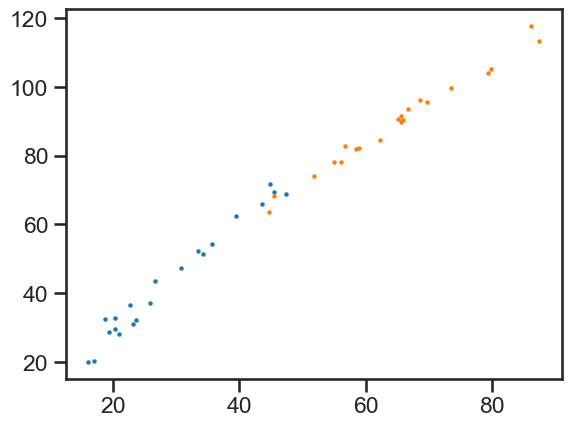

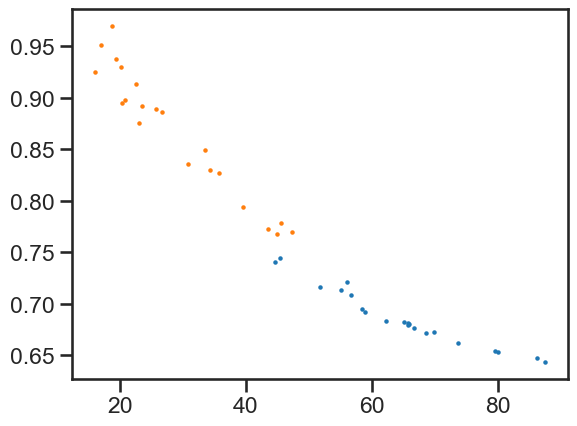

In [1024]:
plt.scatter(I_low_g, I_high_g, s=3)
plt.scatter(I_low_b, I_high_b, s=3)
plt.show()
plt.scatter(I_low_b, R_b, s=3)
plt.scatter(I_low_g, R_g, s=3)
plt.show()

In [1070]:
def plot_dis(low_mask, high_mask):
    I_low_g = [rock.mean() for rock, m in zip(results_0219[-1][0], high_mask) if m]
    I_high_g = [rock.mean() for rock, m in zip(results_0219[-1][1], high_mask) if m]

    R_g = R_0219_mean[0:99][high_mask]
    R_b = R_0219_mean[0:99][low_mask]
    I_low_b = [rock.mean() for rock, m in zip(results_0219[-1][0], low_mask) if m]
    I_high_b = [rock.mean() for rock, m in zip(results_0219[-1][1], low_mask) if m]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].scatter(I_low_g, I_high_g, s=3, label='ore')
    axes[0].scatter(I_low_b, I_high_b, s=3, label='waste')
    axes[0].set_xlabel('I_low')
    axes[0].set_ylabel('I_high')

    x1 = np.linspace(axes[0].get_xlim()[0], axes[0].get_xlim()[1], 100)
    axes[0].plot(x1, x1, color='red', linestyle='--', label='y = x', alpha = 0.6)

    axes[0].legend(frameon=False)

    axes[1].scatter(I_low_g, R_g, s=3, label='ore')
    axes[1].scatter(I_low_b, R_b, s=3, label='waste')
    axes[1].set_xlabel('I_low')
    axes[1].set_ylabel('R')
    axes[1].legend(frameon=False)

    plt.show()

    return {'I_low_g':I_low_g, 
            'I_high_g':I_high_g, 
            'R_g':R_g, 
            'I_low_b':I_low_b, 
            'I_high_b':I_high_b, 
            'R_b':R_b}

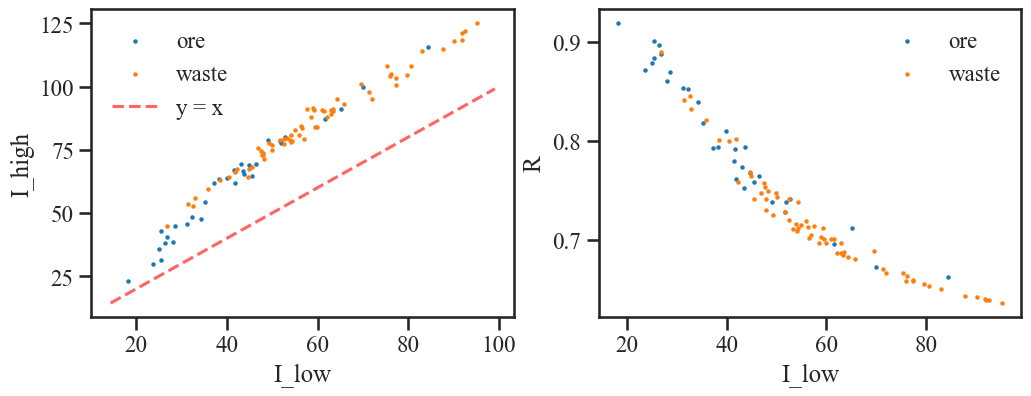

In [1061]:
high_mask = zn_pb_0219[0:99] > 3
plot_dis(~high_mask, high_mask)

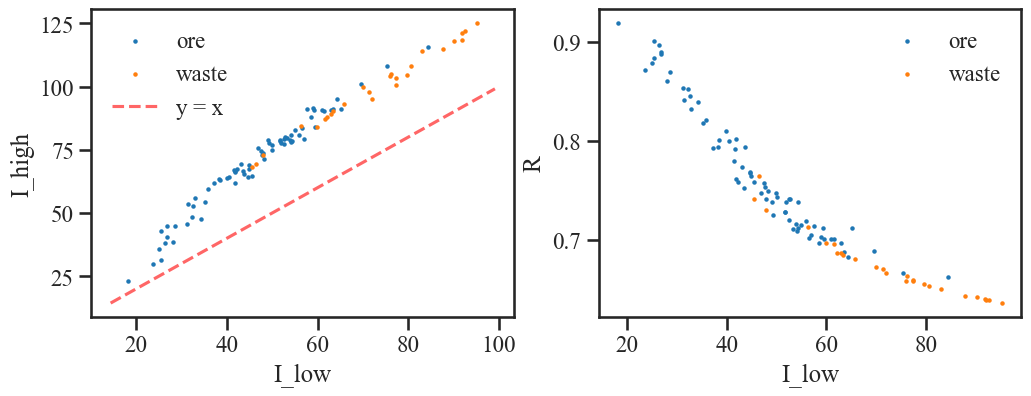

In [1071]:
high_mask = zn_pb_fe_0219[0:99] > 10
dis_fe = plot_dis(~high_mask, high_mask)

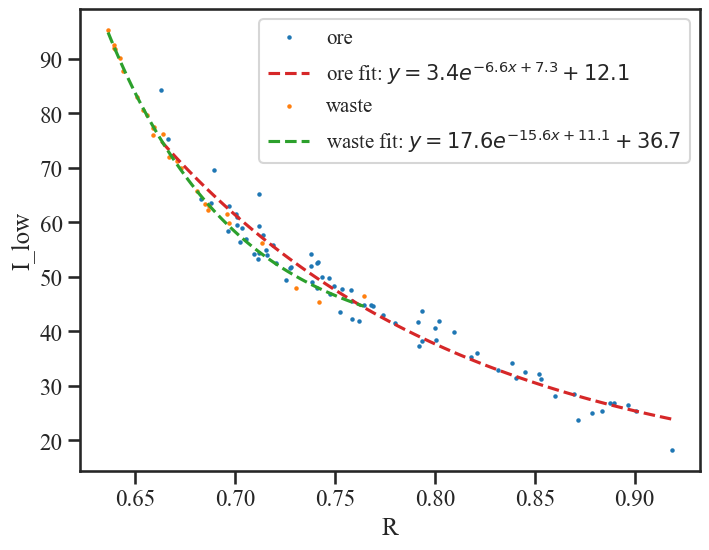

In [1150]:
def exponential_func(x, a, b, c, d):
    return a * np.exp(b * x + c) + d

I_low_g = dis_fe['I_low_g'] 
R_g = dis_fe['R_g']

I_low_b = dis_fe['I_low_b'] 
R_b = dis_fe['R_b']

# 对 ore 数据进行指数拟合
if len(I_low_g) > 0 and len(R_g) > 0:
    popt_ore, pcov  = curve_fit(exponential_func, R_g, I_low_g)
    x_ore = np.linspace(min(R_g), max(R_g), 100)
    y_ore = exponential_func(x_ore, *popt_ore)

# 对 waste 数据进行指数拟合
if len(I_low_b) > 0 and len(R_b) > 0:
    popt_waste, _ = curve_fit(exponential_func, R_b, I_low_b)
    x_waste = np.linspace(min(R_b), max(R_b), 100)
    y_waste = exponential_func(x_waste, *popt_waste)

plt.figure(figsize=(8, 6))
plt.scatter(R_g, I_low_g, s=3, label='ore')

formula_ore = f'$y = {popt_ore[0]:.1f}e^{{{popt_ore[1]:.1f}x + {popt_ore[2]:.1f}}} + {popt_ore[3]:.1f}$'

plt.plot(x_ore, y_ore, '--', color = cycle[3], label=f'ore fit: {formula_ore}')
plt.scatter(R_b, I_low_b, s=3, label='waste')
formula_waste = f'$y = {popt_waste[0]:.1f}e^{{{popt_waste[1]:.1f}x + {popt_waste[2]:.1f}}} + {popt_waste[3]:.1f}$'
plt.plot(x_waste, y_waste, '--', color = cycle[2], label=f'waste fit: {formula_waste}')
plt.legend(fontsize = 15)

plt.ylabel('I_low')
plt.xlabel('R')
plt.show()